### Временной ряд №1

In [130]:
import pandas as pd
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from plotly.graph_objects import * 
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from xgboost import XGBRegressor
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
import category_encoders as ce
from sklearn.metrics import mean_absolute_error
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

In [131]:
df = pd.read_csv(r'...monthly-car-sales.csv')

In [132]:
df = df.groupby('Month').agg({'Sales': sum}).reset_index()

In [133]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [134]:
df['Month']=pd.to_datetime(df['Month'])

<AxesSubplot:xlabel='Month'>

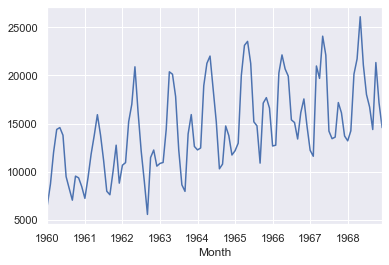

In [135]:
df.set_index('Month')['Sales'].plot()

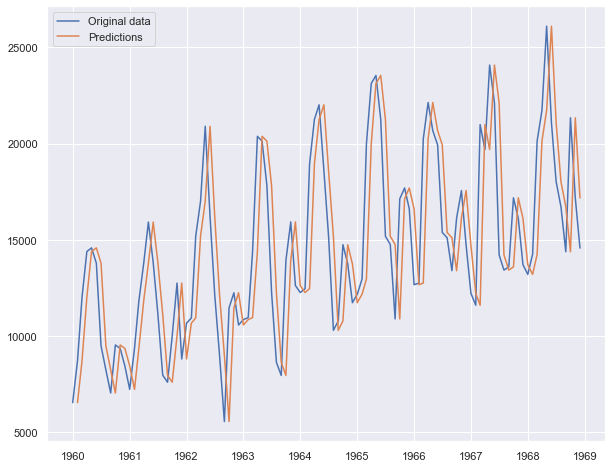

In [136]:
# base line 
target = 'Sales'

df['preds_lags']=df['Sales'].shift(1)


fig, ax = plt.subplots(figsize=(10,8))
plt.plot(df['Month'], df[target], label = 'Original data')
plt.plot(df['Month'], df['preds_lags'], label = 'Predictions')
ax.legend()
plt.show()

In [137]:
df.fillna(0,inplace=True)
mean_absolute_error(df[target],df['preds_lags'])

2665.935185185185

In [138]:
r2_score(df[target],df['preds_lags'])

0.4442244999416174

In [139]:
# Lagged values as featrs

In [140]:
for i in range(1,15):
    df[f'i-{i}'] = df[target].shift(i)

In [141]:
df[['i-'+str(i) for i in range(1,15)]+[target]].corr()[target]

i-1      0.728068
i-2      0.367645
i-3      0.076004
i-4      0.030571
i-5      0.170231
i-6      0.213944
i-7      0.146070
i-8     -0.011016
i-9      0.020582
i-10     0.308732
i-11     0.709073
i-12     0.919575
i-13     0.677495
i-14     0.297376
Sales    1.000000
Name: Sales, dtype: float64

In [142]:
# Linear regression does not handle nulls
df.fillna(df.mean(),inplace=True)

In [143]:
features = ['i-'+str(i) for i in range(1,15)]



error = list()


size = int(len(df)*0.8)
train, test = df[0:size],df[size:]
predictions = list()

for i in range(len(test)):
    step = test[i:i+1]
    mod = LinearRegression()
    mod.fit(train[features],train[target])
    preds = mod.predict(step[features])
    predictions.append(preds[0])
    error.append(mean_absolute_error(step[target],preds))
    
    train = pd.concat([train,step])

In [144]:
np.mean(error)

1835.492366213054

In [145]:
r2_score(test[target],predictions)

0.6676095473768031

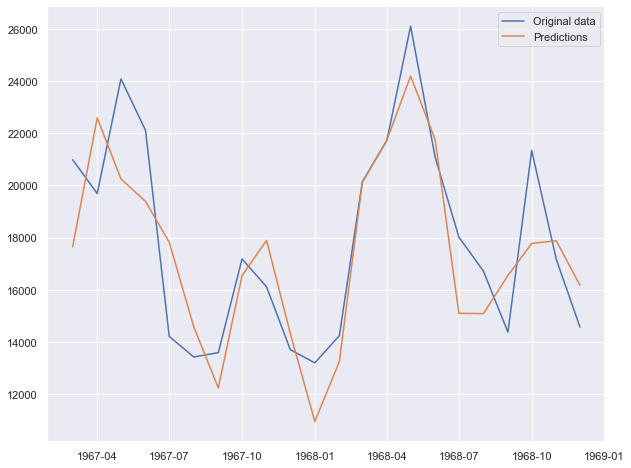

In [146]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(test['Month'], test[target], label = 'Original data')
plt.plot(test['Month'], predictions, label = 'Predictions')
ax.legend()
plt.show()

In [147]:
# Time related featurs

In [148]:
df.columns

Index(['Month', 'Sales', 'preds_lags', 'i-1', 'i-2', 'i-3', 'i-4', 'i-5',
       'i-6', 'i-7', 'i-8', 'i-9', 'i-10', 'i-11', 'i-12', 'i-13', 'i-14'],
      dtype='object')

In [149]:
features = ['Month']

In [150]:
enc = ce.TargetEncoder(cols=features)

In [151]:
error = list()


size = int(len(df)*0.8)
train, test = df[0:size],df[size:]
predictions = list()

for i in range(len(test)):
    step = test[i:i+1]
    train_encoded = enc.fit_transform(train, train[target])
    mod = LinearRegression()
    mod.fit(train_encoded[features],train_encoded[target])
    step_encoded=  enc.transform(step)
    preds = mod.predict(step_encoded[features])
    predictions.append(preds[0])
    error.append(mean_absolute_error(step_encoded[target],preds))
    
    train = pd.concat([train,step])

In [152]:
np.mean(error)

3940.913062614229

In [153]:
r2_score(test[target],predictions)

-0.9920860211266831

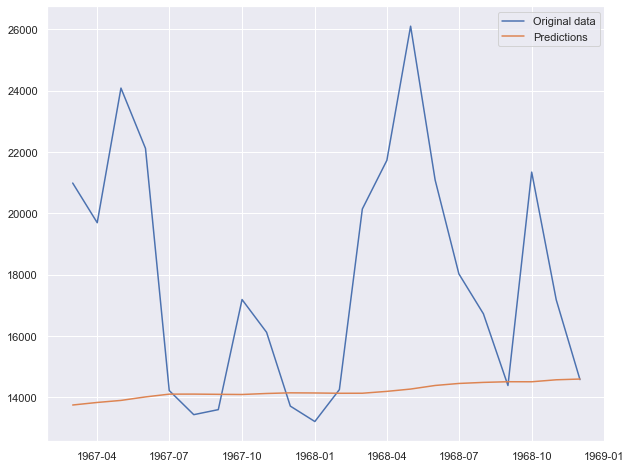

In [154]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(test['Month'], test[target], label = 'Original data')
plt.plot(test['Month'], predictions, label = 'Predictions')
ax.legend()
plt.show()

In [155]:
# Rolling window

df['rolling_window'] = df[target].rolling(7).mean()

In [156]:
mean_absolute_error(df[-len(test):][target], df[-len(test):]['rolling_window'])

3413.9675324675322

In [157]:
r2_score(df[-len(test):][target], df[-len(test):]['rolling_window'])

-0.12337849760809849

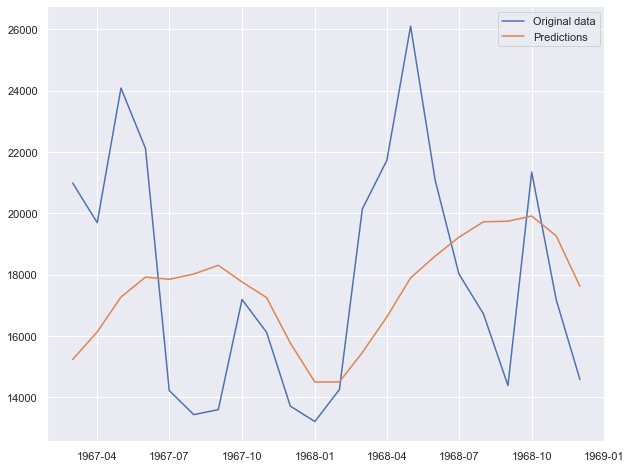

In [158]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(df[-len(test):]['Month'], df[-len(test):][target], label = 'Original data')
plt.plot(df[-len(test):]['Month'], df[-len(test):]['rolling_window'], label = 'Predictions')
ax.legend()
plt.show()

In [159]:
correlations = (df.corr()[target]).sort_values(ascending=False)

In [160]:
correlations

Sales             1.000000
i-12              0.843093
preds_lags        0.736086
i-1               0.717132
i-11              0.657870
i-13              0.610394
rolling_window    0.559494
i-2               0.359074
i-10              0.288881
i-14              0.265300
i-6               0.208533
i-5               0.165963
i-7               0.141414
i-3               0.074101
i-4               0.029804
i-9               0.019407
i-8              -0.010552
Name: Sales, dtype: float64

In [161]:
# Putting them together

In [162]:
lagged_features = ['i-'+str(i) for i in range(1,15)]
cat_features = ['Month']

In [163]:
error = list()


size = int(len(df)*0.8)
train, test = df[0:size],df[size:]
predictions = list()
enc = ce.TargetEncoder(cols=cat_features)
for i in range(len(test)):
    step = test[i:i+1]
    train_encoded = enc.fit_transform(train, train[target])
    mod = LinearRegression()
    mod.fit(train_encoded[cat_features+lagged_features],train_encoded[target])
    step_encoded=  enc.transform(step)
    preds = mod.predict(step_encoded[cat_features+lagged_features])
    predictions.append(preds[0])
    error.append(mean_absolute_error(step_encoded[target],preds))
    
    train = pd.concat([train,step])

In [164]:
np.mean(error)

1835.4923662130604

In [165]:
r2_score(test[target],predictions)

0.6676095473768016

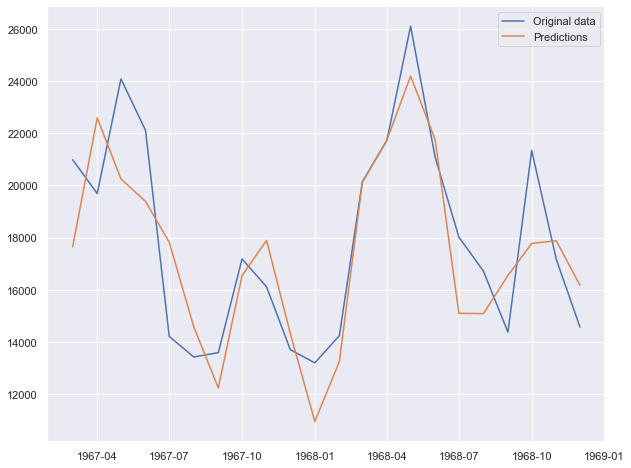

In [166]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(test['Month'], test[target], label = 'Original data')
plt.plot(test['Month'], predictions, label = 'Predictions')
ax.legend()
plt.show()

In [167]:
error = list()


size = int(len(df)*0.8)
train, test = df[0:size],df[size:]
predictions = list()
enc = ce.TargetEncoder(cols=cat_features)
for i in range(len(test)):
    step = test[i:i+1]
    train_encoded = enc.fit_transform(train, train[target])
    mod = LGBMRegressor()
    mod.fit(train_encoded[cat_features+lagged_features],train_encoded[target])
    step_encoded=  enc.transform(step)
    preds = mod.predict(step_encoded[cat_features+lagged_features])
    predictions.append(preds[0])
    error.append(mean_absolute_error(step_encoded[target],preds))
    
    train = pd.concat([train,step])

In [168]:
np.mean(error)

1928.2712411365826

In [169]:
r2_score(test[target],predictions)

0.5685136708452305

### Временной ряд №2

In [170]:
df2 = pd.read_csv(r'...month_value.csv')

In [171]:
df2.head()

,Period,Revenue,Sales_quantity,Average_cost
0,01.01.2015,16010072.12,12729,1257.763541
1,01.02.2015,15807587.45,11636,1358.507000
2,01.03.2015,22047146.02,15922,1384.697024
3,01.04.2015,18814583.29,15227,1235.606705
4,01.05.2015,14021479.61,8620,1626.621765


In [172]:
# correlations
df2.corr()

,Revenue,Sales_quantity,Average_cost
Revenue,1.000000,0.887570,0.358278
Sales_quantity,0.887570,1.000000,-0.093599
Average_cost,0.358278,-0.093599,1.000000


In [173]:
df2 = df2.groupby('Period').agg({'Revenue': sum, 
                               #Sales_quantity': sum, 
                               #'Average_cost': np.mean
                              # }).reset_index()

In [174]:
df2.head()

,Period,Revenue,Sales_quantity,Average_cost
0,01.01.2015,16010072.12,12729,1257.763541
1,01.02.2015,15807587.45,11636,1358.507000
2,01.03.2015,22047146.02,15922,1384.697024
3,01.04.2015,18814583.29,15227,1235.606705
4,01.05.2015,14021479.61,8620,1626.621765


In [175]:
df2['Period']=pd.to_datetime(df2['Period'])

In [176]:
df2.dtypes

Period            datetime64[ns]
Revenue                  float64
Sales_quantity             int64
Average_cost             float64
dtype: object

In [181]:
# не успела :)